# Loan Case Study
#### C. Griffith - BUSI 650 Summer 2022

##### **Objective** 

> To identify the criteria to approve loans for an individual customer such that the likelihood of the loan delinquency is minimized.

## ***Import packages and define functions.***

In [ ]:
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.6.1-py3-none-any.whl size=16265 sha256=8048e11550e9556f5605ee1a0fa5a8c001e023acc757cde4959fb8ed5a4b8d15
  Stored in directory: /root/.cache/pip/wheels/e8/81/8f/29aafd7d671a4e9db4e976d71728870173f0b3f48ccba0bc32
Successfully built pandarallel


In [ ]:
# import packages
from google.colab import drive
import copy
from pandarallel import pandarallel
from math import log2, sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, 
    PrecisionRecallDisplay, average_precision_score, auc
)
%matplotlib inline 
sns.set(color_codes=True)
sns.set(style="darkgrid")
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## ***Read the dataset into pandas dataframes.***

In [ ]:
# Authorization of GDrive
drive.mount('/content/drive/')

# Change working directory location to datasets
%cd /content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets

# Load dataset
data = pd.read_csv('Loan_Delinquent_Dataset.csv')

loan_df = data.copy()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets


## ***EDA***

In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11548 non-null  int64 
 1   isDelinquent    11548 non-null  int64 
 2   term            11548 non-null  object
 3   gender          11548 non-null  object
 4   purpose         11548 non-null  object
 5   home_ownership  11548 non-null  object
 6   age             11548 non-null  object
 7   FICO            11548 non-null  object
dtypes: int64(2), object(6)
memory usage: 721.9+ KB


In [ ]:
loan_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,11548.0,NaN,NaN,NaN,5774.5,3333.764789,1.0,2887.75,5774.5,8661.25,11548.0
isDelinquent,11548.0,NaN,NaN,NaN,0.668601,0.470737,0.0,0.0,1.0,1.0,1.0
term,11548,2,36 months,10589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,11548,2,Male,6555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purpose,11548,7,House,6892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,11548,3,Mortgage,5461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,11548,2,20-25,5888,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FICO,11548,2,300-500,6370,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# show number of null values in each column
loan_df.isnull().sum()

ID                0
isDelinquent      0
term              0
gender            0
purpose           0
home_ownership    0
age               0
FICO              0
dtype: int64

In [ ]:
loan_df.columns.values

array(['ID', 'isDelinquent', 'term', 'gender', 'purpose',
       'home_ownership', 'age', 'FICO'], dtype=object)

In [ ]:
# # create dummy variables 'term', 'gender', 'purpose', 'home_ownership', 'age', 'FICO'
loan_df_w_dummies = pd.get_dummies(loan_df, columns=['term', 'gender', 'purpose', 'home_ownership', 'age', 'FICO'])

In [ ]:
loan_df_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   ID                       11548 non-null  int64
 1   isDelinquent             11548 non-null  int64
 2   term_36 months           11548 non-null  uint8
 3   term_60 months           11548 non-null  uint8
 4   gender_Female            11548 non-null  uint8
 5   gender_Male              11548 non-null  uint8
 6   purpose_Car              11548 non-null  uint8
 7   purpose_House            11548 non-null  uint8
 8   purpose_Medical          11548 non-null  uint8
 9   purpose_Other            11548 non-null  uint8
 10  purpose_Personal         11548 non-null  uint8
 11  purpose_Wedding          11548 non-null  uint8
 12  purpose_other            11548 non-null  uint8
 13  home_ownership_Mortgage  11548 non-null  uint8
 14  home_ownership_Own       11548 non-null  uint8
 15  ho

In [ ]:
# drop excess feature 
loan_df_w_dummies = loan_df_w_dummies.drop(columns=['term_36 months', 
                                                    'gender_Female', 
                                                    'purpose_other', 
                                                    'home_ownership_Own', 
                                                    'age_20-25', 
                                                    'FICO_300-500', 
                                                    'ID'])

loan_df_w_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   isDelinquent             11548 non-null  int64
 1   term_60 months           11548 non-null  uint8
 2   gender_Male              11548 non-null  uint8
 3   purpose_Car              11548 non-null  uint8
 4   purpose_House            11548 non-null  uint8
 5   purpose_Medical          11548 non-null  uint8
 6   purpose_Other            11548 non-null  uint8
 7   purpose_Personal         11548 non-null  uint8
 8   purpose_Wedding          11548 non-null  uint8
 9   home_ownership_Mortgage  11548 non-null  uint8
 10  home_ownership_Rent      11548 non-null  uint8
 11  age_>25                  11548 non-null  uint8
 12  FICO_>500                11548 non-null  uint8
dtypes: int64(1), uint8(12)
memory usage: 225.7 KB


## ***Modeling***

In [ ]:
# Separating the target variable and features
X = loan_df_w_dummies.drop(['isDelinquent'], axis=1) 
y = loan_df_w_dummies['isDelinquent']
class_labels = [0,1]

In [ ]:
# split 70/30
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=3)

###Parameters for each classifier

In [ ]:
###Parameters for each classifier

####(1) Decision Tree ([Library](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier))

legend_label_DTC = ['log(N)', 'sqrt(N)', 'N/2', 'N'] #number of features to consider at each split (plot legend)
N_DTC = len(X.columns) # total features in dataset
considered_features_DTC = ['log2', 'auto', round(N_DTC/2), None] #number of features to consider at each split
features_per_config_DTC = [round(log2(N_DTC)), round(sqrt(N_DTC)), round(float(N_DTC/2)), N_DTC] # num of features per configuration

predictions_DTC = [] # stores predictions 
accuracies_by_num_features_DTC = [] # stores accuracies 
cms_DTC = [] # stores confusion matrices 
probs_DTC = [] # stores score probabilities of the test data 

####(2) Random Forest ([Library](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier))

legend_label_RFC = ['log(N)', 'sqrt(N)', 'N/2', 'N'] #number of features to consider at each split (plot legend)
N_RFC = len(X.columns) # total features in dataset
considered_features_RFC = ['log2', 'auto', round(N_RFC/2), None] #number of features to consider at each split
features_per_config_RFC = [round(log2(N_RFC)), round(sqrt(N_RFC)), round(float(N_RFC/2)), N_RFC ] # num of features per configuration
n_of_base_learners_RFC = [1, 10, 50, 100, 500, 1000, 5000] #number of base learners

predictions_RFC = [] # stores predictions for each RandomForestClassifier model
accuracies_by_num_features_RFC = [] # stores accuracies for each RandomForestClassifier model
cms_RFC = [] # stores confusion matrices for each RandomForestClassifier model
probs_RFC = [] # stores score probabilities of the test data for each RandomForestClassifier model

####(3) & (4) Boosting (Ada) Ensemble with logistic regression classifier as the base learner, AdaBoost Ensemble with Decision Tree as the base learner ([Library](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier))

legend_label_Boost = ['log(N)', 'sqrt(N)', 'N/2', 'N'] #number of features to consider at each split (plot legend)
N_Boost = len(X.columns) # total features in dataset
considered_features_Boost = ['log2', 'auto', round(N_Boost/2), None] #number of features to consider at each split
features_per_config_Boost = [round(log2(N_Boost)), round(sqrt(N_Boost)), round(float(N_Boost/2)), N_Boost ] # num of features per configuration
n_of_base_learners_Boost = [1, 10, 50, 100, 500, 1000, 5000] #number of base learners

predictions_Boost = [] # stores predictions
accuracies_by_num_base_learners_Boost = [] # stores accuracies
cms_Boost = [] # stores confusion matrices
probs_Boost = [] # stores score probabilities of the test data

### Functions for each classifier

In [ ]:
### Functions for each classifier

####(1) Decision Trees

def initialize_DTC():
  predictions_DTC.clear()
  accuracies_by_num_features_DTC.clear()
  cms_DTC.clear()
  probs_DTC.clear()

def DTC_predictions():  

  print("------BEGIN: Decision Tree Classifiers------")
  # loop through each tunable model
  for index, feature_config in enumerate(tqdm(considered_features_DTC, ascii=True, unit='Feature Config')):

    print('')
    print("---------------------------")
    print('')
    print("Feature Config:", legend_label_DTC[index], "= {} Features".format(features_per_config_DTC[index]))

    # classifier
    dtc = DecisionTreeClassifier(criterion = "entropy", random_state = rng_seed,  max_features=feature_config)

    # train rfc model using training split
    dtc.fit(X_train,Y_train)

    # apply model to test split
    Y_pred = dtc.predict(X_test)
    Y_score = dtc.predict_proba(X_test)
    
    # store predictions, accuracy and probability scores
    predictions_DTC.append(Y_pred)
    accuracies_by_num_features_DTC.append(accuracy_score(Y_test, Y_pred))
    probs_DTC.append(Y_score)

    # store confusion matrix
    cm = confusion_matrix(Y_test, Y_pred, labels=class_labels)
    cms_DTC.append(cm)

    # display stats
    print("\nAccuracy:", round(accuracies_by_num_features_DTC[index]*100,4), "%\n")
 
    TN, FP, FN, TP = cms_DTC[index].ravel()

    print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cms_DTC[index], display_labels=class_labels)
    cm_display.plot()
    plt.show()

    # True Positive Rate TPR = TP/(TP+FN)
    TPR = TP/(TP+FN)
    print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

    # True Negative Rate TNR = TN/(TN+FP)
    TNR = TN/(FP+TN)
    print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

    # False Positive Rate FPR = FP/(FP+TN)
    FPR = FP/(FP+TN)
    print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

    # False Negative Rate FNR = FN/(FN+TP)
    FNR = FN/(FN+TP)
    print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

    # Precision
    PRECISION = TP/(TP+FP)
    print("Precision Rate =",round(PRECISION*100, 4), "%")

    # Recall
    RECALL = TP/(TP+FN)
    print("Recall Rate =",round(RECALL*100, 4), "%\n")

    # get false and true positive rates
    fpr, tpr, thresholds_roc = roc_curve(Y_test, probs_DTC[index][:,1], pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # get area under the curve
    roc_auc = auc(fpr, tpr)

    # get prec and recall rates
    prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs_DTC[index][:,1], pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # get area under the curve
    pr_auc = auc(recall, prec)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 5)

    ax1.plot(fpr, tpr, lw=1)
    ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
    ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
    ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
    ax1.set_xlim([-.1, 1.1])

    ax2.plot(recall, prec, lw=1)
    ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
    ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
    ax2.set(xlabel = 'Recall', ylabel = 'Precision')
    ax2.set_xlim([-.1, 1.1])

    plt.tight_layout()
    plt.show()

  print("\n-----END-----")

# Plot graphs (RFC)
def plot_all_graphs_DTC():

  # plot Accuracies of DTCs vs Num of Features 

  adj_range = range(len(features_per_config_DTC))

  plt.plot(adj_range, accuracies_by_num_features_DTC, marker="o")

  print('\n-------DTCs SUMMARY-------\n')
  #plt.legend(legend_label_DTC, loc="best")
  plt.title("Accuracies of DTCs vs Number of Features")
  plt.ylabel(f"Accuracies")
  plt.xlabel("Number of Features")
  plt.xticks(adj_range, features_per_config_DTC)

  plt.show()

def best_accuracy_DTC():
  best_estimator = ['', 0, 0]
  max_index = 0
  
  max_accuracy = max(accuracies_by_num_features_DTC)
  max_index = accuracies_by_num_features_DTC.index(max_accuracy)

  print('\n-----BEST PERFORMANCE-----\n')
  print("Feature Config:", legend_label_DTC[max_index], "= {} Features with accuracy:".format(features_per_config_DTC[max_index]), round(max_accuracy*100, 4), "%\n")

  cm = cms_DTC[max_index]

  TN, FP, FN, TP = cm.ravel()

  print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  cm_display.plot()
  plt.show()

  # True Positive Rate TPR = TP/(TP+FN)
  TPR = TP/(TP+FN)
  print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

  # True Negative Rate TNR = TN/(TN+FP)
  TNR = TN/(FP+TN)
  print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

  # False Positive Rate FPR = FP/(FP+TN)
  FPR = FP/(FP+TN)
  print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

  # False Negative Rate FNR = FN/(FN+TP)
  FNR = FN/(FN+TP)
  print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

  # Precision
  PRECISION = TP/(TP+FP)
  print("Precision Rate =",round(PRECISION*100, 4), "%")

  # Recall
  RECALL = TP/(TP+FN)
  print("Recall Rate =",round(RECALL*100, 4), "%\n")

  # get false and true positive rates
  fpr, tpr, thresholds_roc = roc_curve(Y_test, probs_DTC[max_index][:,1], pos_label=1)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

  # get area under the curve
  roc_auc = auc(fpr, tpr)

  # get prec and recall rates
  prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs_DTC[max_index][:,1], pos_label=1)
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

  # get area under the curve
  pr_auc = auc(recall, prec)

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(8, 5)

  ax1.plot(fpr, tpr, lw=1)
  ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
  ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
  ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
  ax1.set_xlim([-.1, 1.1])

  ax2.plot(recall, prec, lw=1)
  ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
  ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
  ax2.set(xlabel = 'Recall', ylabel = 'Precision')
  ax2.set_xlim([-.1, 1.1])

  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
  plt.show()

def DTC_Evaluation():
  initialize_DTC()
  DTC_predictions()
  plot_all_graphs_DTC()
  best_accuracy_DTC()

####(2) Random Forest

def initialize_RFC():
  predictions_RFC.clear()
  accuracies_by_num_features_RFC.clear()
  cms_RFC.clear()
  probs_RFC.clear()

def RFC_predictions():  

  print("------BEGIN: Random Forest Classifiers------")
  # loop through each tunable model
  for index, feature_config in enumerate(tqdm(considered_features_RFC, ascii=True, unit='Feature Config')):

    print('')
    print("---------------------------")
    print('')
    print("Feature Config:", legend_label_RFC[index], "= {} Features".format(features_per_config_RFC[index]))
    
    predictions = []
    accuracies = []
    cms = []
    probs = []

    for base_learner in tqdm(n_of_base_learners_RFC, ascii=True, unit='Base Learners Config'):

      # classifier
      rfc = RandomForestClassifier(n_estimators=base_learner, criterion = "entropy", bootstrap = True, random_state = rng_seed, max_features=feature_config)

      # train rfc model using training split
      rfc.fit(X_train,Y_train)

      # apply model to test split
      Y_pred = rfc.predict(X_test)
      Y_score = rfc.predict_proba(X_test)
     
      # store predictions, accuracy abd probability scores
      predictions.append(Y_pred)
      accuracies.append(accuracy_score(Y_test, Y_pred))
      probs.append(Y_score)

      # store confusion matrix
      cm = confusion_matrix(Y_test, Y_pred, labels=class_labels)
      cms.append(cm)
    
    predictions_RFC.append(predictions)
    accuracies_by_num_features_RFC.append(accuracies)
    cms_RFC.append(cms)
    probs_RFC.append(probs)

    # display stats of best classifier by Base Learner Config
    max_accuracy = max(accuracies)
    max_index = accuracies.index(max_accuracy)
    print("\nMax Accuracy ({} base learners):".format(n_of_base_learners_RFC[max_index]), round(max_accuracy*100,4), "%\n")
 
    TN, FP, FN, TP = cms[max_index].ravel()

    print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cms[max_index], display_labels=class_labels)
    cm_display.plot()
    plt.show()

    # True Positive Rate TPR = TP/(TP+FN)
    TPR = TP/(TP+FN)
    print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

    # True Negative Rate TNR = TN/(TN+FP)
    TNR = TN/(FP+TN)
    print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

    # False Positive Rate FPR = FP/(FP+TN)
    FPR = FP/(FP+TN)
    print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

    # False Negative Rate FNR = FN/(FN+TP)
    FNR = FN/(FN+TP)
    print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

    # Precision
    PRECISION = TP/(TP+FP)
    print("Precision Rate =",round(PRECISION*100, 4), "%")

    # Recall
    RECALL = TP/(TP+FN)
    print("Recall Rate =",round(RECALL*100, 4), "%\n")

    # get false and true positive rates
    fpr, tpr, thresholds_roc = roc_curve(Y_test, probs[max_index][:,1], pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # get area under the curve
    roc_auc = auc(fpr, tpr)

    # get prec and recall rates
    prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs[max_index][:,1], pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # get area under the curve
    pr_auc = auc(recall, prec)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 5)

    ax1.plot(fpr, tpr, lw=1)
    ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
    ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
    ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
    ax1.set_xlim([-.1, 1.1])

    ax2.plot(recall, prec, lw=1)
    ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
    ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
    ax2.set(xlabel = 'Recall', ylabel = 'Precision')
    ax2.set_xlim([-.1, 1.1])

    plt.tight_layout()
    plt.show()

  print("\n-----END-----")

# Plot graphs (RFC)
def plot_all_graphs_RFC():

  # plot Accuracies of RFCs vs Number of Base Learners 
  line_style = ['-', '--', '-.', ':']

  adj_range = range(len(n_of_base_learners_RFC))

  for index, accuracies in enumerate(accuracies_by_num_features_RFC):
    plt.plot(adj_range, accuracies, line_style[index], marker="o")

  print('\n-------RFCs SUMMARY-------\n')
  plt.legend(legend_label_RFC, loc="best")
  plt.title("Accuracies of RFCs vs Number of Base Learners")
  plt.ylabel(f"Accuracies")
  plt.xlabel("Number of Base Learners")
  plt.xticks(adj_range, n_of_base_learners_RFC)

  plt.show()


def best_accuracy_RFC():
  best_estimator = ['', 0, 0, 0, 0]
  max_index = 0
  for index, accuracies in enumerate(accuracies_by_num_features_RFC):
      max_accuracy = max(accuracies)
      max_index = accuracies.index(max_accuracy)

      if best_estimator[4] < max_accuracy:
        best_estimator[0] = legend_label_RFC[index]
        best_estimator[1] = index
        best_estimator[2] = n_of_base_learners_RFC[max_index]
        best_estimator[3] = max_index
        best_estimator[4] = max_accuracy

  print('\n-----BEST PERFORMANCE-----\n')
  print("Feature Config:", best_estimator[0], " = {} Features with accuracy ({} base learners):".format(features_per_config_RFC[best_estimator[1]],best_estimator[2]), round(best_estimator[4]*100, 4), "%\n")

  cm = cms_RFC[best_estimator[1]][best_estimator[3]]

  TN, FP, FN, TP = cm.ravel()

  print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  cm_display.plot()
  plt.show()

  # True Positive Rate TPR = TP/(TP+FN)
  TPR = TP/(TP+FN)
  print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

  # True Negative Rate TNR = TN/(TN+FP)
  TNR = TN/(FP+TN)
  print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

  # False Positive Rate FPR = FP/(FP+TN)
  FPR = FP/(FP+TN)
  print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

  # False Negative Rate FNR = FN/(FN+TP)
  FNR = FN/(FN+TP)
  print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

  # Precision
  PRECISION = TP/(TP+FP)
  print("Precision Rate =",round(PRECISION*100, 4), "%")

  # Recall
  RECALL = TP/(TP+FN)
  print("Recall Rate =",round(RECALL*100, 4), "%\n")

  # get false and true positive rates
  fpr, tpr, thresholds_roc = roc_curve(Y_test, probs_RFC[best_estimator[1]][best_estimator[3]][:,1], pos_label=1)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

  # get area under the curve
  roc_auc = auc(fpr, tpr)

  # get prec and recall rates
  prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs_RFC[best_estimator[1]][best_estimator[3]][:,1], pos_label=1)
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

  # get area under the curve
  pr_auc = auc(recall, prec)

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(8, 5)

  ax1.plot(fpr, tpr, lw=1)
  ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
  ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
  ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
  ax1.set_xlim([-.1, 1.1])

  ax2.plot(recall, prec, lw=1)
  ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
  ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
  ax2.set(xlabel = 'Recall', ylabel = 'Precision')
  ax2.set_xlim([-.1, 1.1])

  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
  plt.show()

def RFC_Evaluation():
  initialize_RFC()
  RFC_predictions()
  plot_all_graphs_RFC()
  best_accuracy_RFC()

####(3) & (4) Boosting (Ada) Ensemble with logistic regression classifier as the base learner, AdaBoost Ensemble with Decision Tree as the base learner

def initialize_Boost():
  predictions_Boost.clear()
  accuracies_by_num_base_learners_Boost.clear()
  cms_Boost.clear()
  probs_Boost.clear()

def Boost_LR_predictions():  

  print("------BEGIN: Boosting Ensemble with Logistic Regression------")
  # loop through each tunable model
  lr_est = LogisticRegression (max_iter = 10000, random_state=rng_seed)  #logistic regression classifier as the base learner

  for index, base_learner in enumerate(tqdm(n_of_base_learners_Boost, ascii=True, unit='Base Learners Config')):

    print('')
    print("---------------------------")
    print('')
    print("Base Learner Config:", base_learner)

    # classifier
    bs_lr = AdaBoostClassifier(n_estimators = base_learner, base_estimator = lr_est)

    # train model using training split
    bs_lr.fit(X_train,Y_train)

    # apply model to test split
    Y_pred = bs_lr.predict(X_test)
    Y_score = bs_lr.predict_proba(X_test)
    
    # store predictions, accuracy abd probability scores
    predictions_Boost.append(Y_pred)
    accuracies_by_num_base_learners_Boost.append(accuracy_score(Y_test, Y_pred))
    probs_Boost.append(Y_score)

    # store confusion matrix
    cm = confusion_matrix(Y_test, Y_pred, labels=class_labels)
    cms_Boost.append(cm)

    # display stats
    print("\nAccuracy:", round(accuracies_by_num_base_learners_Boost[index]*100,4), "%\n")
 
    TN, FP, FN, TP = cms_Boost[index].ravel()

    print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cms_Boost[index], display_labels=class_labels)
    cm_display.plot()
    plt.show()

    # True Positive Rate TPR = TP/(TP+FN)
    TPR = TP/(TP+FN)
    print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

    # True Negative Rate TNR = TN/(TN+FP)
    TNR = TN/(FP+TN)
    print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

    # False Positive Rate FPR = FP/(FP+TN)
    FPR = FP/(FP+TN)
    print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

    # False Negative Rate FNR = FN/(FN+TP)
    FNR = FN/(FN+TP)
    print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

    # Precision
    PRECISION = TP/(TP+FP)
    print("Precision Rate =",round(PRECISION*100, 4), "%")

    # Recall
    RECALL = TP/(TP+FN)
    print("Recall Rate =",round(RECALL*100, 4), "%\n")

    # get false and true positive rates
    fpr, tpr, thresholds_roc = roc_curve(Y_test, probs_Boost[index][:,1], pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # get area under the curve
    roc_auc = auc(fpr, tpr)

    # get prec and recall rates
    prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs_Boost[index][:,1], pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # get area under the curve
    pr_auc = auc(recall, prec)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 5)

    ax1.plot(fpr, tpr, lw=1)
    ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
    ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
    ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
    ax1.set_xlim([-.1, 1.1])

    ax2.plot(recall, prec, lw=1)
    ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
    ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
    ax2.set(xlabel = 'Recall', ylabel = 'Precision')
    ax2.set_xlim([-.1, 1.1])

    plt.tight_layout()
    plt.show()

  print("\n-----END-----")


def Boost_DTC_predictions():  

  print("------BEGIN: AdaBoost Ensemble with Decision Tree------")

  # loop through each tunable model
  for index, feature_config in enumerate(tqdm(considered_features_Boost, ascii=True, unit='Feature Config')):

    print('')
    print("---------------------------")
    print('')
    print("Feature Config:", legend_label_Boost[index], "= {} Features".format(features_per_config_Boost[index]))
    
    predictions = []
    accuracies = []
    cms = []
    probs = []

    # decision tree classifier as the base learner for feature config
    dtc_est = DecisionTreeClassifier(criterion = "entropy", random_state = rng_seed, max_features=feature_config) 

    for base_learner in tqdm(n_of_base_learners_Boost, ascii=True, unit='Base Learners Config'):

      # classifier
      bs_dtc = AdaBoostClassifier(n_estimators = base_learner, base_estimator = dtc_est)

      # train model using training split
      bs_dtc.fit(X_train,Y_train)

      # apply model to test split
      Y_pred = bs_dtc.predict(X_test)
      Y_score = bs_dtc.predict_proba(X_test)
      
      # store predictions, accuracy abd probability scores
      predictions.append(Y_pred)
      accuracies.append(accuracy_score(Y_test, Y_pred))
      probs.append(Y_score)

      # store confusion matrix
      cm = confusion_matrix(Y_test, Y_pred, labels=class_labels)
      cms.append(cm)
    
    predictions_Boost.append(predictions)
    accuracies_by_num_base_learners_Boost.append(accuracies)
    cms_Boost.append(cms)
    probs_Boost.append(probs)

    # display stats of best classifier by Base Learner Config
    max_accuracy = max(accuracies)
    max_index = accuracies.index(max_accuracy)
    print("\nMax Accuracy ({} base learners):".format(n_of_base_learners_Boost[max_index]), round(max_accuracy*100,4), "%\n")

    TN, FP, FN, TP = cms[max_index].ravel()

    print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cms[max_index], display_labels=class_labels)
    cm_display.plot()
    plt.show()

    # True Positive Rate TPR = TP/(TP+FN)
    TPR = TP/(TP+FN)
    print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

    # True Negative Rate TNR = TN/(TN+FP)
    TNR = TN/(FP+TN)
    print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

    # False Positive Rate FPR = FP/(FP+TN)
    FPR = FP/(FP+TN)
    print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

    # False Negative Rate FNR = FN/(FN+TP)
    FNR = FN/(FN+TP)
    print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

    # Precision
    PRECISION = TP/(TP+FP)
    print("Precision Rate =",round(PRECISION*100, 4), "%")

    # Recall
    RECALL = TP/(TP+FN)
    print("Recall Rate =",round(RECALL*100, 4), "%\n")

    # get false and true positive rates
    fpr, tpr, thresholds_roc = roc_curve(Y_test, probs[max_index][:,1], pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

    # get area under the curve
    roc_auc = auc(fpr, tpr)

    # get prec and recall rates
    prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs[max_index][:,1], pos_label=1)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    # get area under the curve
    pr_auc = auc(recall, prec)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 5)

    ax1.plot(fpr, tpr, lw=1)
    ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
    ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
    ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
    ax1.set_xlim([-.1, 1.1])

    ax2.plot(recall, prec, lw=1)
    ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
    ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
    ax2.set(xlabel = 'Recall', ylabel = 'Precision')
    ax2.set_xlim([-.1, 1.1])

    plt.tight_layout()
    plt.show()

  print("\n-----END-----")

def plot_all_graphs_Boost_LR():

  # plot Accuracies vs Num of Features 

  adj_range = range(len(n_of_base_learners_Boost))

  plt.plot(adj_range, accuracies_by_num_base_learners_Boost, marker="o")

  print('\n-------Boost LR SUMMARY-------\n')
  plt.title("Accuracies of Boosting LR vs Number of Base Learners")
  plt.ylabel(f"Accuracies")
  plt.xlabel("Number of Base Learners")
  plt.xticks(adj_range, n_of_base_learners_Boost)

  plt.show()


def plot_all_graphs_Boost_DTC():

  # plot Accuracies  vs Number of Base Learners 
  line_style = ['-', '--', '-.', ':']

  adj_range = range(len(n_of_base_learners_Boost))

  for index, accuracies in enumerate(accuracies_by_num_base_learners_Boost):
    plt.plot(adj_range, accuracies, line_style[index], marker="o")

  print('\n-------BOOST DTC SUMMARY-------\n')
  plt.legend(legend_label_Boost, loc="best")
  plt.title("Accuracies of Boosting DTC vs Number of Base Learners")
  plt.ylabel(f"Accuracies")
  plt.xlabel("Number of Base Learners")
  plt.xticks(adj_range, n_of_base_learners_Boost)

  plt.show()

def best_accuracy_Boost_DTC():
  best_estimator = ['', 0, 0, 0, 0]
  max_index = 0
  for index, accuracies in enumerate(accuracies_by_num_base_learners_Boost):
      max_accuracy = max(accuracies)
      max_index = accuracies.index(max_accuracy)

      if best_estimator[4] < max_accuracy:
        best_estimator[0] = legend_label_Boost[index]
        best_estimator[1] = index
        best_estimator[2] = n_of_base_learners_Boost[max_index]
        best_estimator[3] = max_index
        best_estimator[4] = max_accuracy

  print('\n-----BEST PERFORMANCE-----\n')
  print("Feature Config:", best_estimator[0], " = {} Features with accuracy ({} base learners):".format(features_per_config_Boost[best_estimator[1]],best_estimator[2]), round(best_estimator[4]*100, 4), "%\n")

  cm = cms_Boost[best_estimator[1]][best_estimator[3]]

  TN, FP, FN, TP = cm.ravel()

  print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  cm_display.plot()
  plt.show()

  # True Positive Rate TPR = TP/(TP+FN)
  TPR = TP/(TP+FN)
  print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

  # True Negative Rate TNR = TN/(TN+FP)
  TNR = TN/(FP+TN)
  print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

  # False Positive Rate FPR = FP/(FP+TN)
  FPR = FP/(FP+TN)
  print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%")

  # False Negative Rate FNR = FN/(FN+TP)
  FNR = FN/(FN+TP)
  print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

  # Precision
  PRECISION = TP/(TP+FP)
  print("Precision Rate =",round(PRECISION*100, 4), "%")

  # Recall
  RECALL = TP/(TP+FN)
  print("Recall Rate =",round(RECALL*100, 4), "%\n")

  # get false and true positive rates
  fpr, tpr, thresholds_roc = roc_curve(Y_test, probs_Boost[best_estimator[1]][best_estimator[3]][:,1], pos_label=1)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

  # get area under the curve
  roc_auc = auc(fpr, tpr)

  # get prec and recall rates
  prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs_Boost[best_estimator[1]][best_estimator[3]][:,1], pos_label=1)
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

  # get area under the curve
  pr_auc = auc(recall, prec)

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(8, 5)

  ax1.plot(fpr, tpr, lw=1)
  ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
  ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
  ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
  ax1.set_xlim([-.1, 1.1])

  ax2.plot(recall, prec, lw=1)
  ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
  ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
  ax2.set(xlabel = 'Recall', ylabel = 'Precision')
  ax2.set_xlim([-.1, 1.1])

  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
  plt.show()

def best_accuracy_Boost_LR():
  best_estimator = ['', 0, 0]
  max_index = 0
  
  max_accuracy = max(accuracies_by_num_base_learners_Boost)
  max_index = accuracies_by_num_base_learners_Boost.index(max_accuracy)

  print('\n-----BEST PERFORMANCE-----\n')
  print("Base Learner Config:", n_of_base_learners_Boost[max_index], "Base Learners with accuracy:", round(max_accuracy*100, 4), "%\n")

  cm = cms_Boost[max_index]

  TN, FP, FN, TP = cm.ravel()

  print('(TN, FP, FN, TP) =', (TN, FP, FN, TP),'\n')

  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  cm_display.plot()
  plt.show()

  # True Positive Rate TPR = TP/(TP+FN)
  TPR = TP/(TP+FN)
  print("\nTrue Positive Rate: TPR = TP/(TP+FN) =",round(TPR*100, 4), "%")

  # True Negative Rate TNR = TN/(TN+FP)
  TNR = TN/(FP+TN)
  print("\nTrue Negative Rate: TNR = TN/(TN+FP) =",round(TNR*100, 4), "%")

  # False Positive Rate FPR = FP/(FP+TN)
  FPR = FP/(FP+TN)
  print("\nFalse Positive Rate: FPR = FP/(FP+TN) =",round(FPR*100, 4), "%\n")

  # False Negative Rate FNR = FN/(FN+TP)
  FNR = FN/(FN+TP)
  print("\nFalse Negative Rate: FNR = FN/(FN+TP) =",round(FNR*100, 4), "%\n")

  # Precision
  PRECISION = TP/(TP+FP)
  print("Precision Rate =",round(PRECISION*100, 4), "%")

  # Recall
  RECALL = TP/(TP+FN)
  print("Recall Rate =",round(RECALL*100, 4), "%\n")

  # get false and true positive rates
  fpr, tpr, thresholds_roc = roc_curve(Y_test, probs_Boost[max_index][:,1], pos_label=1)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

  # get area under the curve
  roc_auc = auc(fpr, tpr)

  # get prec and recall rates
  prec, recall, thresholds_prc = precision_recall_curve(Y_test, probs_Boost[max_index][:,1], pos_label=1)
  pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

  # get area under the curve
  pr_auc = auc(recall, prec)

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(8, 5)

  ax1.plot(fpr, tpr, lw=1)
  ax1.plot(FPR, TPR, marker="o", ms = 2, color = 'red')
  ax1.set_title('ROC\nAUC = {}'.format(round(roc_auc,4)))
  ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
  ax1.set_xlim([-.1, 1.1])

  ax2.plot(recall, prec, lw=1)
  ax2.plot(RECALL, PRECISION, marker="o", ms = 2, color = 'red')
  ax2.set_title('PR\nAUC = {}'.format(round(pr_auc,4)))
  ax2.set(xlabel = 'Recall', ylabel = 'Precision')
  ax2.set_xlim([-.1, 1.1])

  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
  plt.show()

def Boost_LR_Evaluation():
  initialize_Boost()
  Boost_LR_predictions()
  plot_all_graphs_Boost_LR()
  best_accuracy_Boost_LR()

def Boost_DTC_Evaluation():
  initialize_Boost()
  Boost_DTC_predictions()
  plot_all_graphs_Boost_DTC()
  best_accuracy_Boost_DTC()

### Model

In [ ]:
print("Maximum Features (N) = {}".format(len(X.columns)))
print("Records = {} \n".format(len(X)))

print("Class Distribution - Pre Split")
print(round((y.value_counts()/y.shape)*100,4))

print("\nClass Distribution - Post Split")

print("Train Set")
print(round((Y_train.value_counts() / len(Y_train))*100, 4))
print("Test Set")
print(round((Y_test.value_counts() / len(Y_test))*100,4))

Maximum Features (N) = 12
Records = 11548 

Class Distribution - Pre Split
1    66.8601
0    33.1399
Name: isDelinquent, dtype: float64

Class Distribution - Post Split
Train Set
1    66.9801
0    33.0199
Name: isDelinquent, dtype: float64
Test Set
1    66.5801
0    33.4199
Name: isDelinquent, dtype: float64


------BEGIN: Boosting Ensemble with Logistic Regression------


  0%|          | 0/7 [00:00<?, ?Base Learners Config/s]


---------------------------

Base Learner Config: 1

Accuracy: 66.5801 %

(TN, FP, FN, TP) = (0, 1158, 0, 2307) 



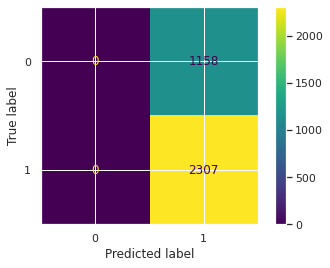


True Positive Rate: TPR = TP/(TP+FN) = 100.0 %

True Negative Rate: TNR = TN/(TN+FP) = 0.0 %

False Positive Rate: FPR = FP/(FP+TN) = 100.0 %

False Negative Rate: FNR = FN/(FN+TP) = 0.0 %

Precision Rate = 66.5801 %
Recall Rate = 100.0 %



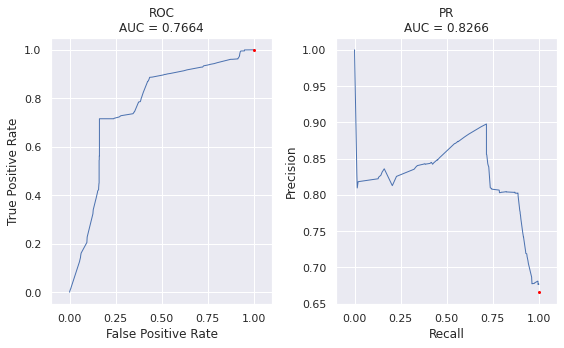


---------------------------

Base Learner Config: 10

Accuracy: 66.5801 %

(TN, FP, FN, TP) = (0, 1158, 0, 2307) 



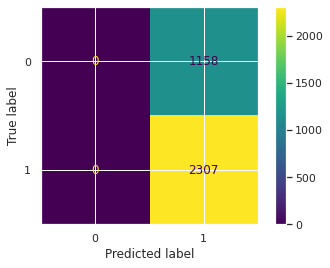


True Positive Rate: TPR = TP/(TP+FN) = 100.0 %

True Negative Rate: TNR = TN/(TN+FP) = 0.0 %

False Positive Rate: FPR = FP/(FP+TN) = 100.0 %

False Negative Rate: FNR = FN/(FN+TP) = 0.0 %

Precision Rate = 66.5801 %
Recall Rate = 100.0 %



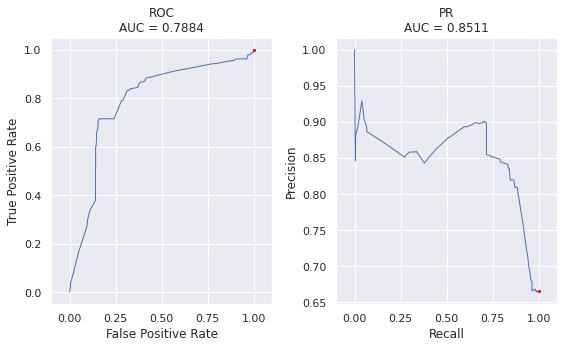


---------------------------

Base Learner Config: 50

Accuracy: 77.114 %

(TN, FP, FN, TP) = (620, 538, 255, 2052) 



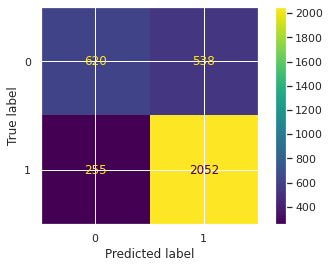


True Positive Rate: TPR = TP/(TP+FN) = 88.9467 %

True Negative Rate: TNR = TN/(TN+FP) = 53.5406 %

False Positive Rate: FPR = FP/(FP+TN) = 46.4594 %

False Negative Rate: FNR = FN/(FN+TP) = 11.0533 %

Precision Rate = 79.2278 %
Recall Rate = 88.9467 %



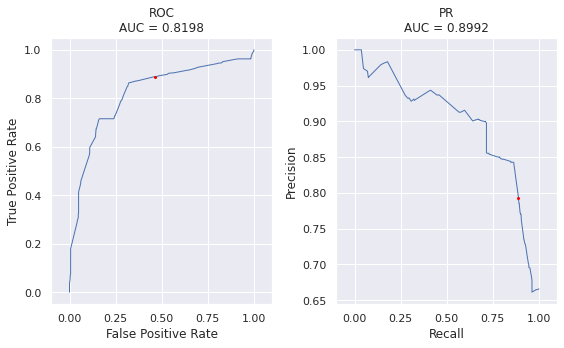


---------------------------

Base Learner Config: 100

Accuracy: 77.0851 %

(TN, FP, FN, TP) = (618, 540, 254, 2053) 



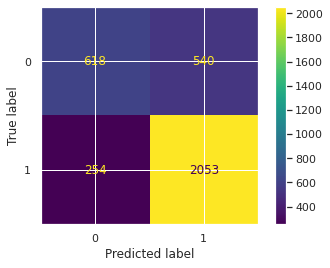


True Positive Rate: TPR = TP/(TP+FN) = 88.99 %

True Negative Rate: TNR = TN/(TN+FP) = 53.3679 %

False Positive Rate: FPR = FP/(FP+TN) = 46.6321 %

False Negative Rate: FNR = FN/(FN+TP) = 11.01 %

Precision Rate = 79.1747 %
Recall Rate = 88.99 %



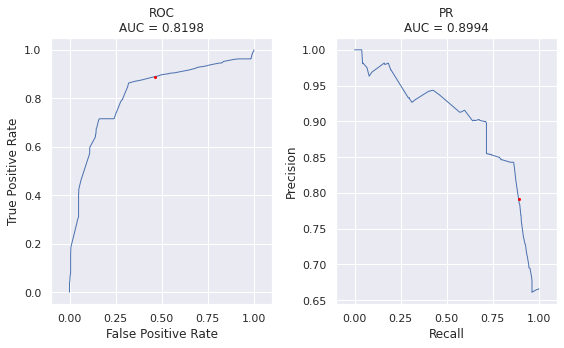


---------------------------

Base Learner Config: 500

Accuracy: 78.4416 %

(TN, FP, FN, TP) = (690, 468, 279, 2028) 



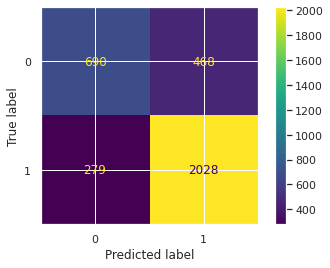


True Positive Rate: TPR = TP/(TP+FN) = 87.9064 %

True Negative Rate: TNR = TN/(TN+FP) = 59.5855 %

False Positive Rate: FPR = FP/(FP+TN) = 40.4145 %

False Negative Rate: FNR = FN/(FN+TP) = 12.0936 %

Precision Rate = 81.25 %
Recall Rate = 87.9064 %



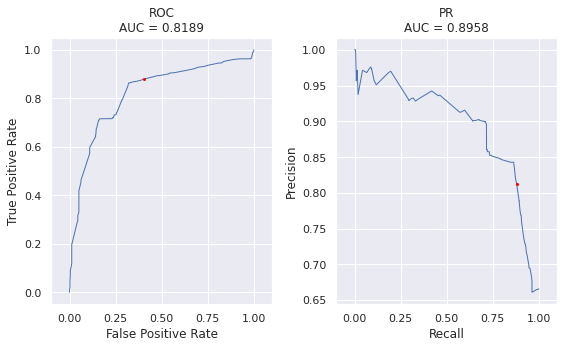


---------------------------

Base Learner Config: 1000

Accuracy: 78.4416 %

(TN, FP, FN, TP) = (690, 468, 279, 2028) 



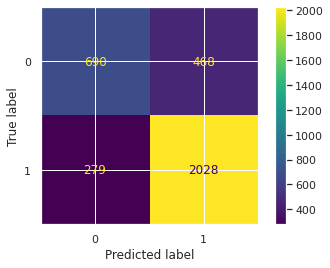


True Positive Rate: TPR = TP/(TP+FN) = 87.9064 %

True Negative Rate: TNR = TN/(TN+FP) = 59.5855 %

False Positive Rate: FPR = FP/(FP+TN) = 40.4145 %

False Negative Rate: FNR = FN/(FN+TP) = 12.0936 %

Precision Rate = 81.25 %
Recall Rate = 87.9064 %



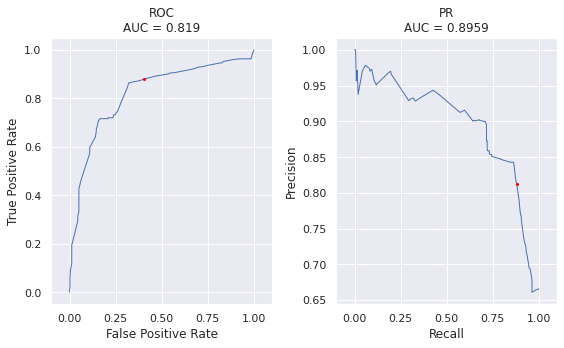


---------------------------

Base Learner Config: 5000

Accuracy: 78.4416 %

(TN, FP, FN, TP) = (690, 468, 279, 2028) 



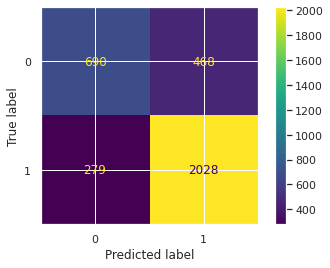


True Positive Rate: TPR = TP/(TP+FN) = 87.9064 %

True Negative Rate: TNR = TN/(TN+FP) = 59.5855 %

False Positive Rate: FPR = FP/(FP+TN) = 40.4145 %

False Negative Rate: FNR = FN/(FN+TP) = 12.0936 %

Precision Rate = 81.25 %
Recall Rate = 87.9064 %



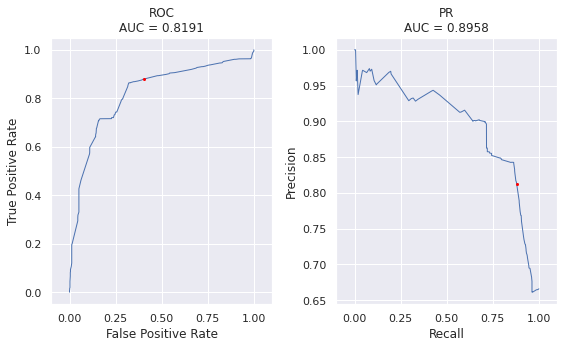


-----END-----

-------Boost LR SUMMARY-------



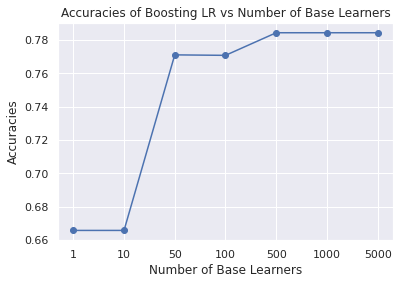


-----BEST PERFORMANCE-----

Base Learner Config: 500 Base Learners with accuracy: 78.4416 %

(TN, FP, FN, TP) = (690, 468, 279, 2028) 



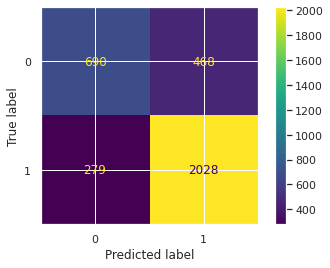


True Positive Rate: TPR = TP/(TP+FN) = 87.9064 %

True Negative Rate: TNR = TN/(TN+FP) = 59.5855 %

False Positive Rate: FPR = FP/(FP+TN) = 40.4145 %


False Negative Rate: FNR = FN/(FN+TP) = 12.0936 %

Precision Rate = 81.25 %
Recall Rate = 87.9064 %



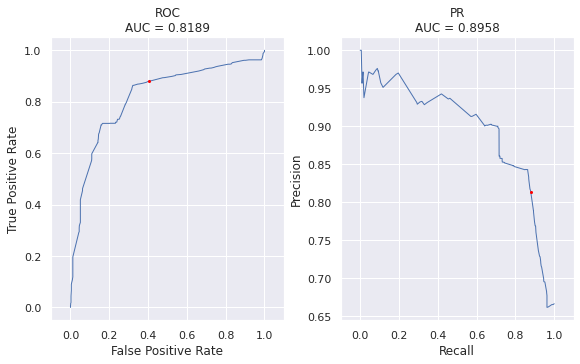

In [ ]:
rng_seed = None
#DTC_Evaluation()
#RFC_Evaluation()
Boost_LR_Evaluation()
#Boost_DTC_Evaluation()